In [1]:
!nvidia-smi

Sat Sep 19 19:27:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.82       Driver Version: 451.82       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:68:00.0  On |                  N/A |
| 56%   56C    P0    61W / 260W |   1061MiB / 11264MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [90]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Conv2D,LeakyReLU,BatchNormalization,Flatten,Dense,Reshape,Conv2DTranspose,Activation
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import matplotlib
import matplotlib.pyplot as plt
from imutils import build_montages
import numpy as np
import pickle
import cv2
import glob
import os
from tqdm.auto import tqdm

In [91]:
# DataGenerator class for handling big set of images
class DataGenerator(Sequence):
    def __init__(self, img_ids, batch_size=32, img_shape=(512,512,3), learning=True):
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.img_ids = img_ids
        self.learning = learning

    def __len__(self):
        return int(np.ceil(len(self.img_ids) / self.batch_size)) + 1

    def __getitem__(self, batch_id):
        batch_imgs = self.img_ids[batch_id * self.batch_size : (batch_id + 1) * self.batch_size]

        X = np.empty((self.batch_size, *self.img_shape))

        for i, img_id in enumerate(batch_imgs):
            X[i,] = cv2.imread(img_id).astype("float32") / 255.0
            
        if self.learning:
            return X, X
        else:
            print(f"Batch: {batch_id}/{int(np.ceil(len(self.img_ids) / self.batch_size)) + 1}", end="\r")
            return X
    
    def on_epoch_end(self):
        if self.learning:
            np.random.shuffle(self.img_ids)


In [3]:
# Function to create the autoencoder model based on input configuration
def Build_Autoencoder(inputShape=(512,512,3), filters=(32,64), latentDim=16):
    # "encoder" part
    inputs = Input(shape=inputShape)
    x = inputs

    # loop over the number of filters
    for f in filters:
        x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=-1)(x)

    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim, name="encoded")(x)

    # "decoder" part
    x = Dense(np.prod(volumeSize[1:]))(latent)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

    # loop over our number of filters again, but this time in reverse order
    for f in filters[::-1]:
        x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=-1)(x)

    # Apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
    x = Conv2DTranspose(inputShape[2], (3, 3), padding="same")(x)
    outputs = Activation("sigmoid", name="decoded")(x)

    # Construct and return our autoencoder model
    return Model(inputs, outputs, name="autoencoder")

In [92]:
IMG_PATH = "Data\\12_Icons"
# Limit the number of images on which we will run the autoencoder
TRAIN_NUM = 10000
IMG_SHAPE = (512,512,3)
# Test to train ratio
TEST_RATE = 0.2

# Initialize the number of epochs to train for, initial learning rate and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# Model parameters
#VER=0; MODEL_FEATURES=16; EPOCHS=20; MODEL_LAYERS=(32, 64); BS=32 
#VER=1; MODEL_FEATURES=64; EPOCHS=20; MODEL_LAYERS=(32, 64); BS=32
#VER=2; MODEL_FEATURES=128; EPOCHS=10; MODEL_LAYERS=(32, 64, 128); BS=8
VER=3; MODEL_FEATURES=256; EPOCHS=20; MODEL_LAYERS=(32, 64, 128); BS=20

AUTOENCODER_PATH = "ImageSimilarity"
MODEL_PATH = f"{AUTOENCODER_PATH}/autoencoder{VER}.h5"
FEATURES_PATH = f"{AUTOENCODER_PATH}/features{VER}.pickle"
FREQ_PATH = f"{AUTOENCODER_PATH}/frequencies{VER}.pickle"

PIC1_PATH = f"{AUTOENCODER_PATH}/recon_vis{VER}.png"
PIC2_PATH = f"{AUTOENCODER_PATH}/plot{VER}.png"


In [93]:
# Load images into numpy train and test datasets
file_names = glob.glob(os.path.join(IMG_PATH, "*.png"))

file_names_shuffled = file_names.copy()
np.random.shuffle(file_names_shuffled)

params = {'img_shape':IMG_SHAPE, 
          'batch_size':BS}   
train_set = file_names_shuffled[:TRAIN_NUM]
test_set = file_names_shuffled[TRAIN_NUM : int(TRAIN_NUM * (1 + TEST_RATE))]

# Full data generator
dataset = DataGenerator(file_names, **params, learning=False)

# Split data generators
trainX = DataGenerator(train_set, **params, learning=True)
testX = DataGenerator(test_set, **params, learning=True)
    

In [8]:
# Construct our convolutional autoencoder
autoencoder = Build_Autoencoder(inputShape=IMG_SHAPE, filters=MODEL_LAYERS, latentDim=MODEL_FEATURES)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      

In [9]:
# Train the convolutional autoencoder
H = autoencoder.fit(trainX,
                    validation_data=testX,
                    epochs=EPOCHS,
                    batch_size=BS)

Epoch 1/20
501/501 [==============================] - 142s 284ms/step - loss: 0.0678 - val_loss: 0.0499
Epoch 2/20
501/501 [==============================] - 143s 284ms/step - loss: 0.0488 - val_loss: 0.0408
Epoch 3/20
501/501 [==============================] - 142s 284ms/step - loss: 0.0433 - val_loss: 0.0379
Epoch 4/20
501/501 [==============================] - 142s 284ms/step - loss: 0.0380 - val_loss: 0.0325
Epoch 5/20
501/501 [==============================] - 143s 285ms/step - loss: 0.0342 - val_loss: 0.0320
Epoch 6/20
501/501 [==============================] - 142s 284ms/step - loss: 0.0320 - val_loss: 0.0308
Epoch 7/20
501/501 [==============================] - 143s 285ms/step - loss: 0.0300 - val_loss: 0.0284
Epoch 8/20
501/501 [==============================] - 142s 284ms/step - loss: 0.0281 - val_loss: 0.0271
Epoch 9/20
501/501 [==============================] - 143s 285ms/step - loss: 0.0269 - val_loss: 0.0273
Epoch 10/20
501/501 [==============================] - 143s 284m

In [10]:
# Serialize the autoencoder model to disk
autoencoder.save(MODEL_PATH, save_format="h5")

In [96]:
# Visualize the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(PIC2_PATH)
plt.show()

NameError: name 'H' is not defined

<Figure size 432x288 with 0 Axes>

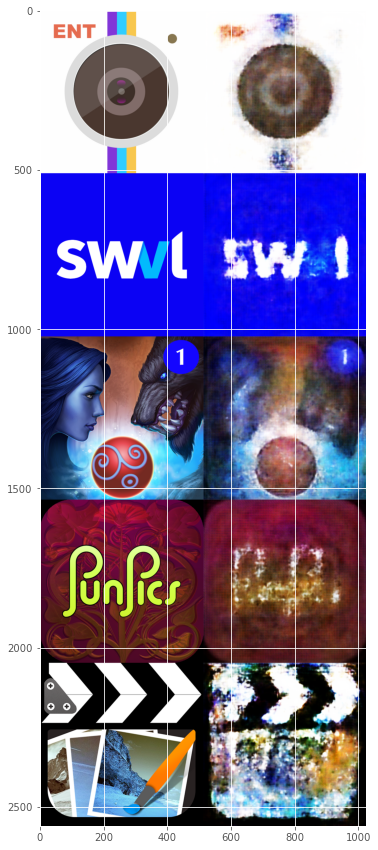

In [12]:
# Let's run the convolutional autoencoder to make image reconstructions on random images
# and visualize some examples
panel = None
samples = 5

for _i in range(samples):
    img_id = file_names[np.random.randint(len(file_names))]

    img = cv2.imread(img_id).astype("float32") / 255.0

    # Get the reconstructed image
    recon = autoencoder.predict(np.expand_dims(img, axis=0),batch_size=1) 

    # Stack the original and reconstructed image side-by-side
    img_row = np.hstack([img, recon[0,:,:,:]])

    # If the panel is yet empty, initialize it with the first pair of images
    if panel is None:
        panel = img_row        
    else:
        panel = np.vstack([panel, img_row])

cv2.imwrite(PIC1_PATH, panel*255)
plt.figure(figsize = (15,15))
plt.imshow(panel)
plt.show()

In [94]:
# Load the learned model from the disk
autoencoder = load_model(MODEL_PATH)

In [14]:
# Now it's time to encode all our images into features
# We need to extract the 'encoder' part of the autoencoder
encoder = Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("encoded").output)

In [16]:
# Run the encoder on full dataset
features = encoder.predict(dataset, batch_size=BS)

# Here we construct a dictionary that maps the name of the 
# image to its corresponding latent-space representation
features_idx = {"name": file_names, "features": features}
features.shape

(109860, 256)

In [17]:
# Write the image features index to disk
with open(FEATURES_PATH, "wb") as f:
    f.write(pickle.dumps(features_idx))

In [5]:
# load image features index from disk
features_idx = pickle.loads(open(FEATURES_PATH, "rb").read())

In [106]:
# loop over the few random images and find and visualize most similar images from the whole dataset
samples = 5
maxResults = 100
countImgs = len(features_idx["name"])

for _i in range(samples):
    
    queryId = np.random.randint(countImgs)
    results = []
    # Find all similar images
    for i in range(countImgs):
        # Compute the euclidean distance between two vectors
        d = np.linalg.norm(features_idx["features"][queryId] - 
                           features_idx["features"][i])
        results.append((d, i))

    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]

    images = []

    # loop over the results
    for (d, i) in results:
        img = cv2.imread(features_idx["name"][i])
        img = np.dstack([img])        
        images.append(img)

    # display the query image
    img = cv2.imread(features_idx["name"][queryId])
    cv2.imshow("Query", img)

    # build a montage from the results and display it
    montage = build_montages(images, (64, 64), (10, 10))[0]
    cv2.imshow("Results", montage)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [103]:
features_idx["name"][queryId][3:]

'icon\\com.ovfcu.mobile.png'